In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import blah
import random
import stim
import stim_model
import cpn_model

torch.autograd.set_detect_anomaly(True)

# We will recapitulate sine waves with various starting
# frequencies. 'steps' is the trial length
steps = 200
batch_size = 256
target = torch.zeros((batch_size, steps, 2))
for bidx in range(batch_size):
    for i in range(-100, 100):
        offset = bidx / float(batch_size)
        t = 6 * (i / 100.0) + offset
        # Dim 1: the target value
        target[bidx, i + 100, 0] = torch.sin(torch.tensor(t))
        # Dim 2: a sort of label of the 'class': an indicator correlated
        #    with the phase at t=0
        target[bidx, i + 100, 1] = torch.tensor(offset)

# A 'Thing' is the thing we are stimulating. It is basically
# a single variable diffeq-goverened system that merely dampens
# over time, except a stimulation can excite it.
class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x
        

In [39]:
# @preston: ignore

ben = stim_model.StimModel(1 + 1, 1, num_neurons=4)

loss = torch.nn.MSELoss()
opt = AdamW(ben.parameters(), lr=2e-3)
for eidx in range(1000):
    ben.reset()
    opt.zero_grad()
    obs = torch.zeros(batch_size, steps)
    preds = torch.zeros(batch_size, steps)  
    cpn = cpn_model.CPNModel(1, 1, num_neurons=7, activation_func=torch.nn.Tanh)
    things = [Thing(init=target[bidx,0].item()) for bidx in range(batch_size)]
    s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
    
    for tidx in range(steps):
        obs[:, tidx] = torch.tensor([t.observe() for t in things])
            
        new_stims = cpn(obs[:, tidx:tidx+1])
        
        noise = torch.tensor([random.uniform(0, 0.5) for _ in range(batch_size)])
            
        stims_actual = new_stims + noise.reshape(batch_size, 1)
        s.add(stims_actual)
        stims_applied = s.get_next()
                       
        for bidx in range(batch_size):
            t = things[bidx]
            t.step(stims_applied[bidx, 0].item())
            
        ben_in = torch.cat((obs[:, tidx:tidx+1], stims_actual), axis=1)
        cur_pred = ben(ben_in)
        preds[:, tidx] = cur_pred.squeeze()            
        
    rl = loss(preds, obs)
    print(eidx, rl.item())
    rl.backward()
    opt.step()
    
    if rl.item() < 0.0001:
        break

#for param in ben.parameters():
#    param.requires_grad=False

0 0.011461343616247177
1 0.006225160323083401
2 0.033238694071769714
3 0.004217834677547216
4 0.008403420448303223
5 0.08076564967632294
6 0.03485611081123352
7 0.015218649059534073
8 0.004217332229018211
9 0.012771641835570335
10 0.009653531946241856
11 0.009800627827644348
12 0.003058101050555706
13 0.004054178949445486
14 0.032528284937143326
15 0.01606479100883007
16 0.032351695001125336
17 0.012614529579877853
18 0.0030384573619812727
19 0.01386015210300684
20 0.00274666678160429
21 0.02975398488342762
22 0.012001285329461098
23 0.004700289573520422
24 0.004478405695408583
25 0.020949263125658035
26 0.006295006722211838
27 0.01032982487231493
28 0.0044526224955916405
29 0.012206614017486572
30 0.0033726906403899193
31 0.004270131699740887
32 0.004057195968925953
33 0.021654000505805016
34 0.0066370065324008465
35 0.005759277381002903
36 0.0037643141113221645
37 0.0027739661745727062
38 0.003788968315348029
39 0.0034001916646957397
40 0.002608775394037366
41 0.0031897390726953745
4

325 0.0033664468210190535
326 0.0010714050149545074
327 0.0007835125434212387
328 0.0005443430854938924
329 0.0016489194240421057
330 0.001529940403997898
331 0.0005404430557973683
332 0.0005109512130729854
333 0.002096929820254445
334 0.0004308009520173073
335 0.0028551635332405567
336 0.00043577014002949
337 0.0005625035846605897
338 0.0006279496592469513
339 0.0008634060504846275
340 0.0015454392414540052
341 0.0006221616640686989
342 0.0007380476454272866
343 0.0006239124340936542
344 0.0008106535533443093
345 0.000506042328197509
346 0.00067752820905298
347 0.0009685725090093911
348 0.0006022847956046462
349 0.0005870216991752386
350 0.0005853529437445104
351 0.0005127742188051343
352 0.0006424941238947213
353 0.0019039884209632874
354 0.0003465269401203841
355 0.0034239927772432566
356 0.000952554342802614
357 0.002825555857270956
358 0.0006002907175570726
359 0.0007906168466433883
360 0.0006518075824715197
361 0.0007973228930495679
362 0.0014737691963091493
363 0.000765296572353

642 0.000754477281589061
643 0.0004653986543416977
644 0.0005155216786079109
645 0.0002541049325373024
646 0.0006664429674856365
647 0.0008797490736469626
648 0.0007227917667478323
649 0.0006217759801074862
650 0.0002974064846057445
651 0.0003562546626199037
652 0.00035957805812358856
653 0.0003349571779835969
654 0.0008428867440670729
655 0.0007417015149258077
656 0.0006475212285295129
657 0.0004730952496174723
658 0.00041087850695475936
659 0.00025151463341899216
660 0.0006705615087412298
661 0.0005023002158850431
662 0.0007003076607361436
663 0.000884576584212482
664 0.0008528639446012676
665 0.0002867346629500389
666 0.0003968671662732959
667 0.0004956703050993383
668 0.000507242395542562
669 0.002033860655501485
670 0.0009365381556563079
671 0.00092748599126935
672 0.0007731625228188932
673 0.00035420554922893643
674 0.00039104430470615625
675 0.0006285650306381285
676 0.00026521499967202544
677 0.00035248248605057597
678 0.0011191761586815119
679 0.0005536351236514747
680 0.00034

956 0.0007766455528326333
957 0.0004963353276252747
958 0.00025564877432771027
959 0.0002548541233409196
960 0.0014523162972182035
961 0.0008497932576574385
962 0.0003849273198284209
963 0.0008647891227155924
964 0.000450470601208508
965 0.0007392920670099556
966 0.0002672526170499623
967 0.0004203874559607357
968 0.0002300160558661446
969 0.000661078083794564
970 0.0005700357141904533
971 0.0005202621105127037
972 0.00036340244696475565
973 0.000893539167009294
974 0.0003800530976150185
975 0.00035897523048333824
976 0.0002896100631915033
977 0.0008015417261049151
978 0.0007616403745487332
979 0.00040688380249775946
980 0.00025732521316967905
981 0.0002158679417334497
982 0.0006152319838292897
983 0.0025923876091837883
984 0.001388154923915863
985 0.00022786900808569044
986 0.00034887506626546383
987 0.00041069212602451444
988 0.0010797185823321342
989 0.0008998085395433009
990 0.0006423842278309166
991 0.00030578728183172643
992 0.00024123850744217634
993 0.00023514153144787997
994 0

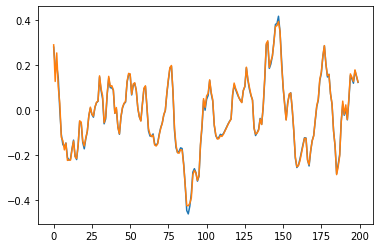

In [4]:
plt.plot(hist[0,:])
plt.plot(pred[0,:].detach().numpy())
plt.show()

In [ ]:
# @preston: this is the core learning algorithm, and seems to be
# able to converge if the problem is structured in a sane way.
#
# In essence: this training loop trains until the (B)EN reaches a
#  certain threshold of loss on the untrained CPN. This can take
#  awhile to converge. Once it does, the CPN will be trained. The
#  BEN is then retrained until it converges again. That way: we only
#  ever train the CPN on an 'accurate' BEN.
#
# Adding the "label" input, which is the second column in target, is
# necessary. Alternatively once could start every trial at the same
# phase - basically memorizing one exact sine wave.

# An observation of a 1 dimensional thing, 1 dimension of stimulation, 1 dimension 'label'
#  1 dimension output, predicting the next state of the thing.
ben = stim_model.StimModel(1 + 1 + 1, 1, num_neurons=7, activation_func=torch.nn.ReLU)
#  1 dimension of stim param, output
cpn = cpn_model.CPNModel(1 + 1, 1, num_neurons=7, activation_func=torch.nn.Tanh)

loss = torch.nn.MSELoss()
opt_cpn = AdamW(cpn.parameters(), lr=5e-3)
opt_ben = AdamW(ben.parameters(), lr=5e-3)
rli = 1
opt_str = "ben"

ben_losses = []
cpn_losses = []
for eidx in range(20000):
    cpn.reset()
    ben.reset()
    opt_cpn.zero_grad()
    opt_ben.zero_grad()
    
    #if rli < 1e-5 and opt_str == "ben":
    if rli < 1e-4 and opt_str == "ben":
        opt_str = "cpn"
        for param in cpn.parameters():
            param.requires_grad=True
        for param in ben.parameters():
            param.requires_grad=False
    else:
        opt_str = "ben"
        for param in cpn.parameters():
            param.requires_grad=False
        for param in ben.parameters():
            param.requires_grad=True

    # Probably more interesting to always start at 0, or
    thing = [Thing(init=x.item()) for x in target[:, 0, 0]]
    
    cur = target[:, 0, :].reshape(256,2)
    pred = torch.zeros((256, steps))
    # This is actually very simple in our single variable context: it outputs
    # a stimulation value which decays to 0 over time.
    # The 'padding' is a cludgy, ugly thing that you can ignore; it's for
    #  the purpose of applying to the Michaels model. I may remove it later.
    s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)

    obs = [t.observe() for t in thing]
    new_obs = torch.tensor(obs).reshape(256,1)
    
    all_obs = torch.zeros(256, steps)
    prev_stim = None

    for tidx in range(steps):
        ind = target[:, tidx, 1].reshape(256,1)
        cpn_in = torch.cat((new_obs, ind), axis=1)
        new_stim = cpn(cpn_in)

        s.add(new_stim)
        n = s.get_next()

        obs = []
        for bidx in range(256):
            thing[bidx].step(n[bidx, 0].item())
            obs.append(thing[bidx].observe())

        new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
        all_obs[:, tidx:tidx+1] = new_obs
        
        ben_in = torch.cat((new_obs, new_stim, ind), axis=1)
        cur_pred = ben(ben_in)
        pred[:, tidx] = cur_pred.squeeze()
        
        prev_stim = new_stim

    if opt_str == "ben":
        rl = loss(pred, all_obs)
    else:
        rl = loss(pred, target[:, :, 0])
        
    rli = rl.item()
    rl.backward()
    
    if opt_str == "ben":
        print(opt_str, eidx, rl.item())
        ben_losses.append(rli)
        opt_ben.step()
    else:
        print(opt_str, eidx, rl.item())
        cpn_losses.append(rli)
        opt_cpn.step()

plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0, :, 0].detach().numpy())
plt.show()

In [ ]:
plt.plot(pred[1,:].detach().numpy())
plt.plot(all_obs[1,:].detach().numpy())
plt.plot(target[1,:,0].detach().numpy())
plt.show()

In [ ]:
# Looks like trash
plt.plot(cpn_losses)

In [ ]:
# Example targets
    
plt.plot(target[0,:,0])
plt.plot(target[200,:,0])
    
plt.show()

In [ ]:
# Direct observation (no EN). Looks like trash. But if I 'observe' the target,
# the CPN acts generally correct. I clearly have the problem structured
# wrong. 
cpn.reset()
stims = torch.zeros(200,1)
thing = Thing(init=target[-2,0,0].item())
outs = torch.zeros(200,steps)
s = stim.StimulusGaussianExp(1, 1, batch_size=1, pad_right_neurons=1)

for tidx in range(steps):
    obs = torch.tensor(thing.observe()).reshape(1,1)
    outs[tidx,:] = obs
    
    #cur = target[-2, tidx, :].reshape(1,2)
    cur = torch.cat((obs, target[-2, tidx, 1].reshape(1,1)), axis=1)
    stims[tidx,:] = cpn(cur)
    #stims[tidx,:] = cpn(obs)
    
    s.add(stims[tidx,:])
    thing.step(s.get_next()[0,:1].item())
    
print(cpn.x)

#plt.plot(stims.detach().numpy())
plt.plot(outs.detach().numpy())
plt.plot(target[-2,:,0].detach().numpy())